# Benchmarking ZARR performance on gridded data

Once ZARR data has been downloaded onto the cluster it is going to be worked on, we need to be able to compute with it efficiently. This includes finding the most efficient chunking scheme with which to use the data.

## Methods
We used a 2 clusters each with 1031 GB of memory and 128 cores with 64 workers (1 worker to 2 cores). We chose such a high number of workers because the data had a large number of chunks. First, we loaded up the data which was 1000 hours of AORC Forcing data in 2013. To speed up test iteration time, we only re-chunk and save the 'Rainrate' data point. The chunk schemes tested are as followed.

In [5]:
chunkSchemes = [
  {'name': "Day-Med", 'scheme': {"time": 24, "x": 80, "y": 70}},
  {'name': "Week-Med", 'scheme': {"time": 24*7, "x": 80, "y": 70}},
  {'name': "Month-Med", 'scheme': {"time": 24*7*4, "x": 80, "y": 70}},
  {'name': "Day-Small", 'scheme': {"time": 24, "x": 8, "y": 7}},
  {'name': "Week-Small", 'scheme': {"time": 24*7, "x": 8, "y": 7}},
  {'name': "Month-Small", 'scheme': {"time": 24*7*4, "x": 8, "y": 7}},
  ]

Afterward, we run a series of benchmark tests with varying sizes of observation. These tests are run 5 times and averaged. The template of tests are below:

In [1]:
def DoWork(dataset, size, time):
    area = dataset.isel(x=size[0], y=size[1], time=time)
    values = area["RAINRATE"].mean(dim="time").compute().values
    return values

## Results
Below are some performance graphs generated from the benchmark.

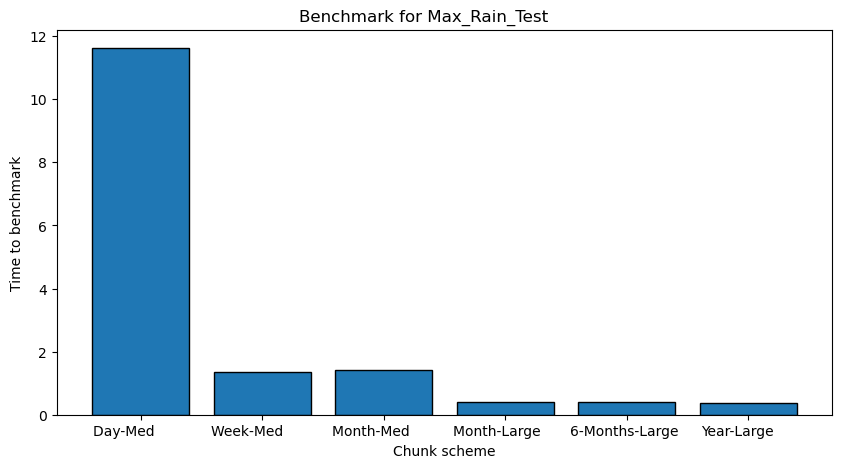

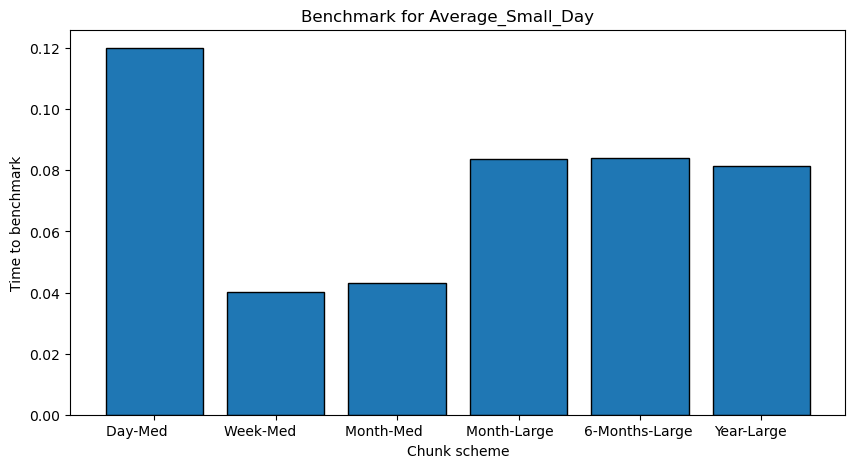

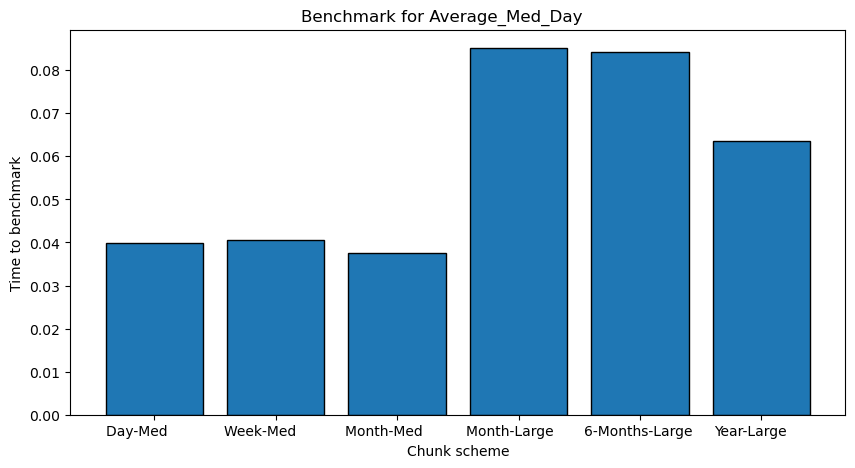

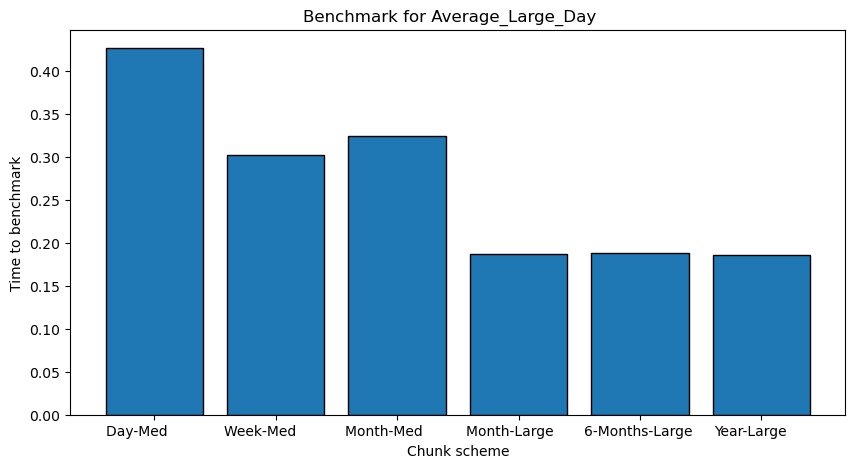

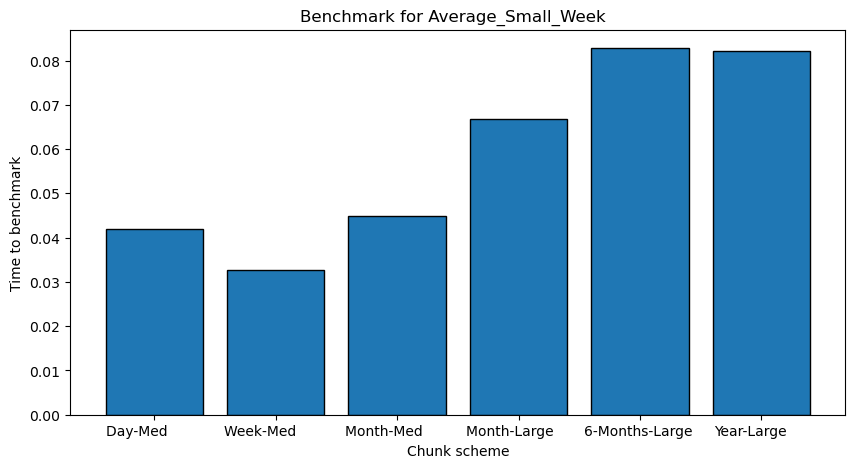

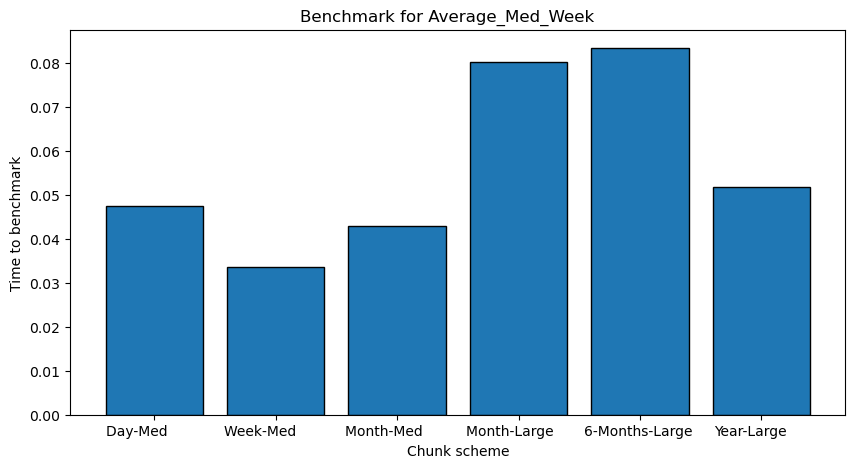

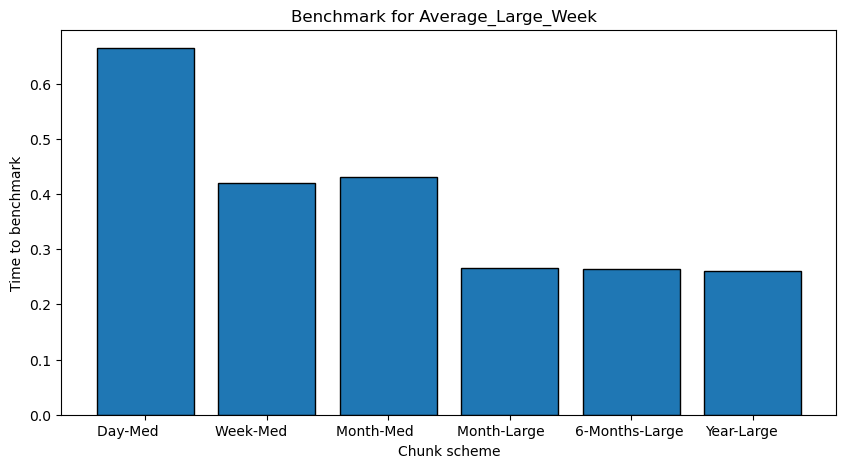

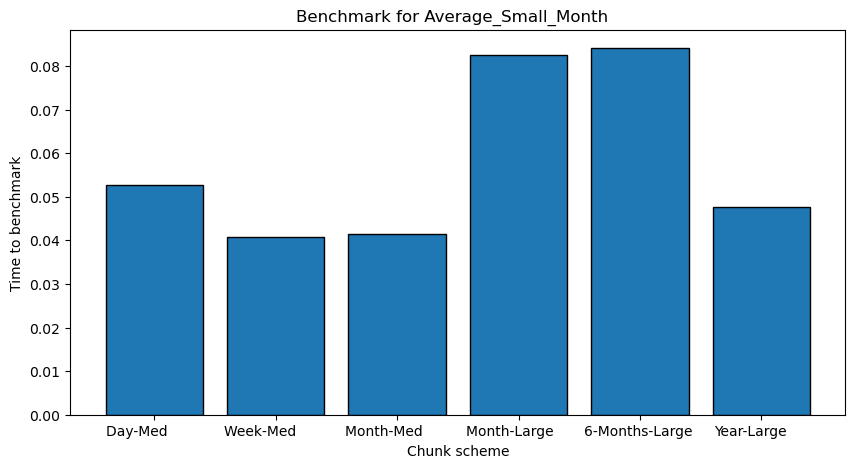

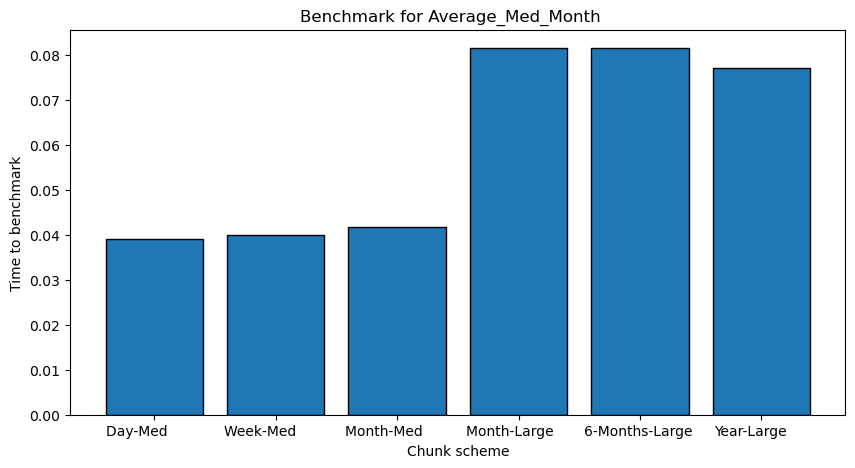

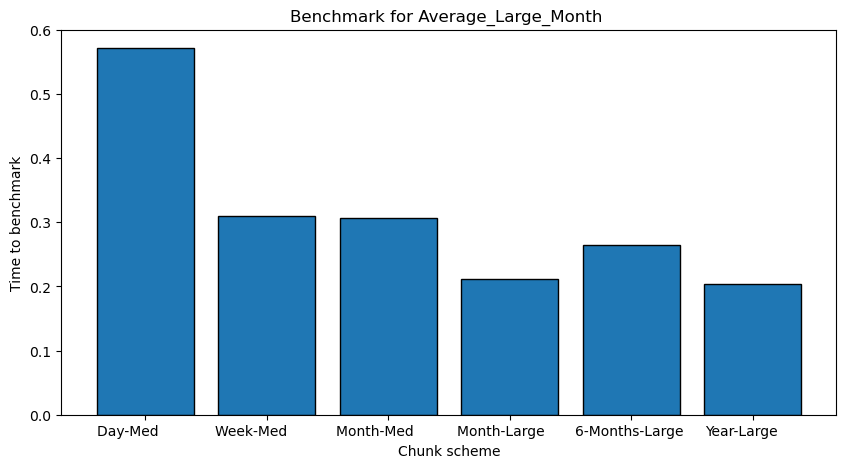

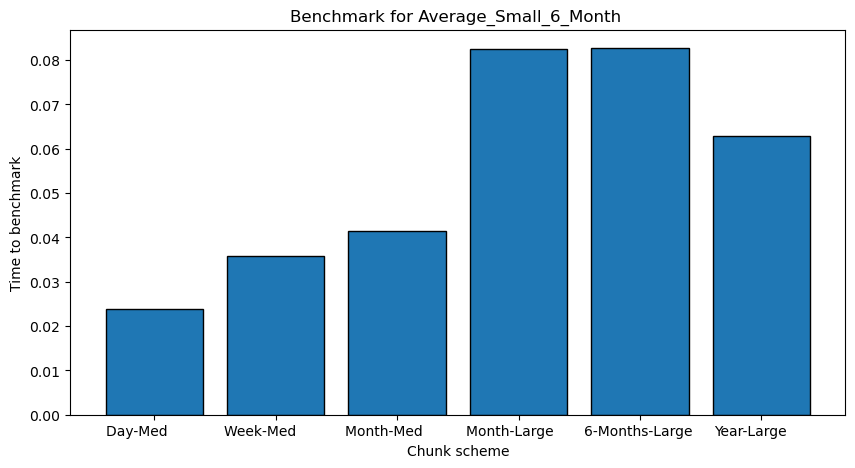

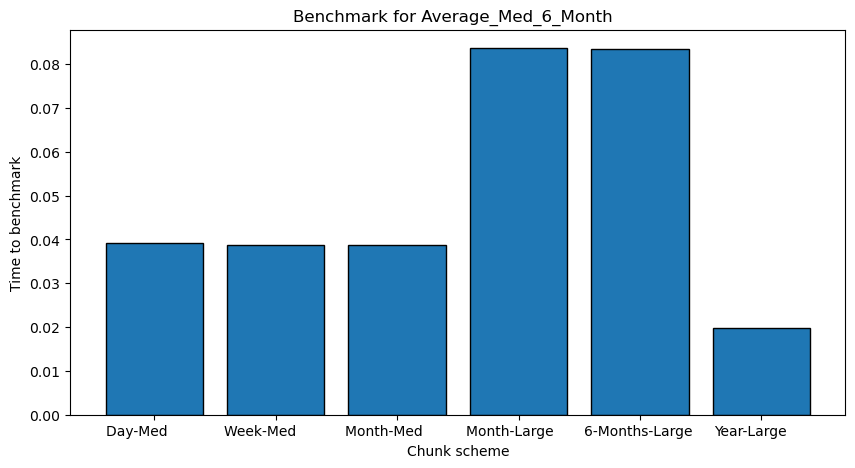

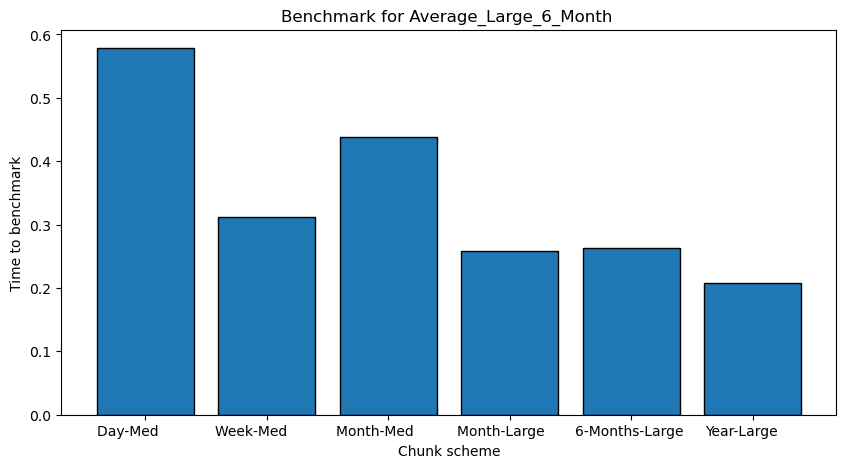

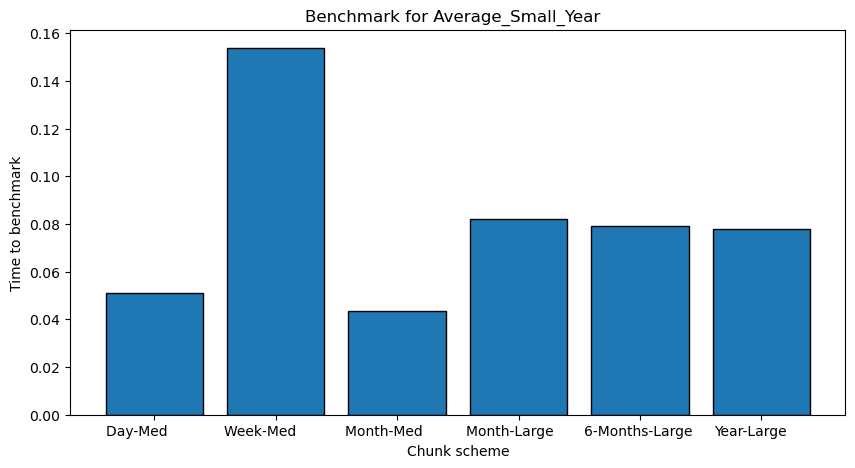

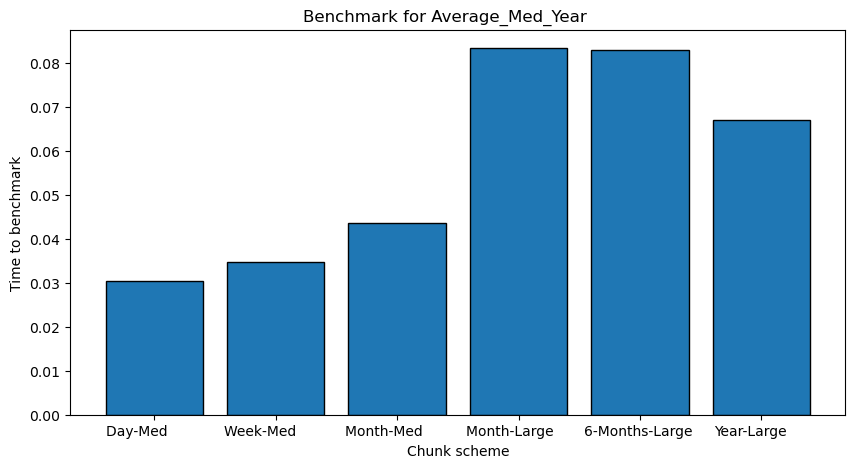

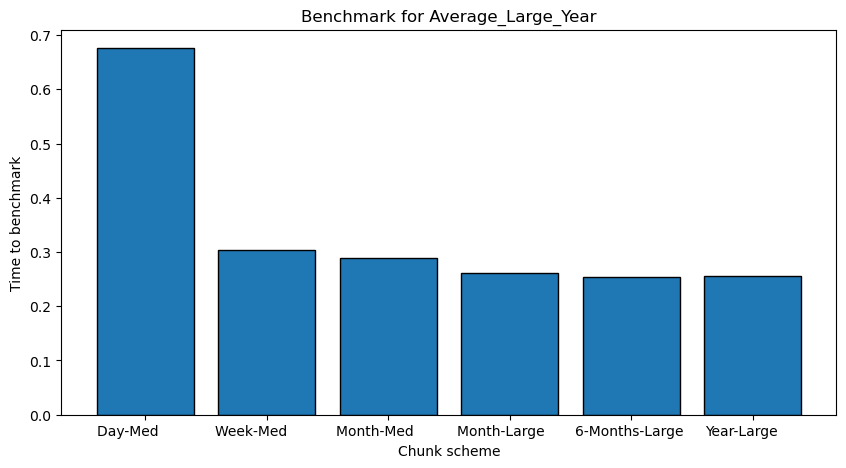

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("/home/x-michaelade/Github/dataminecloudoptimized/Script/Output/computeTimes.csv")

keys = df.keys()
n = np.arange(len(df[keys[0]]))

i = 0
for key in keys:
  if key == keys[0]:
    continue
  plt.bar(df[keys[0]], df[key], label=key, edgecolor='black')
  plt.xlabel("Chunk scheme")
  plt.ylabel("Time to benchmark")
  plt.title(f"Benchmark for {key}")
  plt.show()

## Recommendation
From the graphs, we see a clear trend that the more the chunks align with the data being requested the greater the performance of the dask computation. This poses a challenge to a database designer that wants to design a system that can service a varied number of requests. As a result, I would recommend choosing a chunk size that spans over a medium area across a week. This is a good medium ground for all the most common requests that would be done by a researcher.

## Notes
- Larger chunk sizes seem to be somewhat efficient in compute however it requires sending a large amount of data through the communication layer between the Dask workers. This can result in a high overhead. It also requires a large amount of work being done in the clean up and memory management steps.
- If higher chunk sizes are chosen, a failure during the process of re-chunking can cause the `xarray.open_mfdataset` function to corrupt the metadata of certain files. This issue was found late in our investigation and more time would have been needed to see weather it was a bug in the function or our implementation.
- The chunk schemes tested here aer admittedly random. In the future, we would test with a combination of day, week, and month and small and medium sizes.